In [ ]:
# !pip install -r requirements.txt 

from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info
import torch

# replace the absolute path to XiaomiMiMo/MiMo-VL-7B-RL
rl_model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "XiaomiMiMo/MiMo-VL-7B-RL",
    torch_dtype=torch.bfloat16,
    attn_implementation="flash_attention_2", # enable FlashAttention for faster inference since MiMo-VL thinks
    device_map="auto",
)

sft_model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "XiaomiMiMo/MiMo-VL-7B-SFT",
    torch_dtype=torch.bfloat16,
    attn_implementation="flash_attention_2", # enable FlashAttention for faster inference since MiMo-VL thinks
    device_map="auto",
)

processor = AutoProcessor.from_pretrained("XiaomiMiMo/MiMo-VL-7B-RL")

/usr/local/lib/python3.12/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [2]:
def inference(model, messages, max_new_tokens=16384, temperature=0.1, top_p=0.95, do_sample=True):
    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    image_inputs, video_inputs = process_vision_info(messages)
    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to(model.device)

    generated_ids = model.generate(
        **inputs, 
        max_new_tokens=max_new_tokens,
        temperature=temperature,
        top_p=top_p,
        do_sample=do_sample,
        pad_token_id=processor.tokenizer.eos_token_id
    )
    generated_ids_trimmed = [
        out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    return output_text

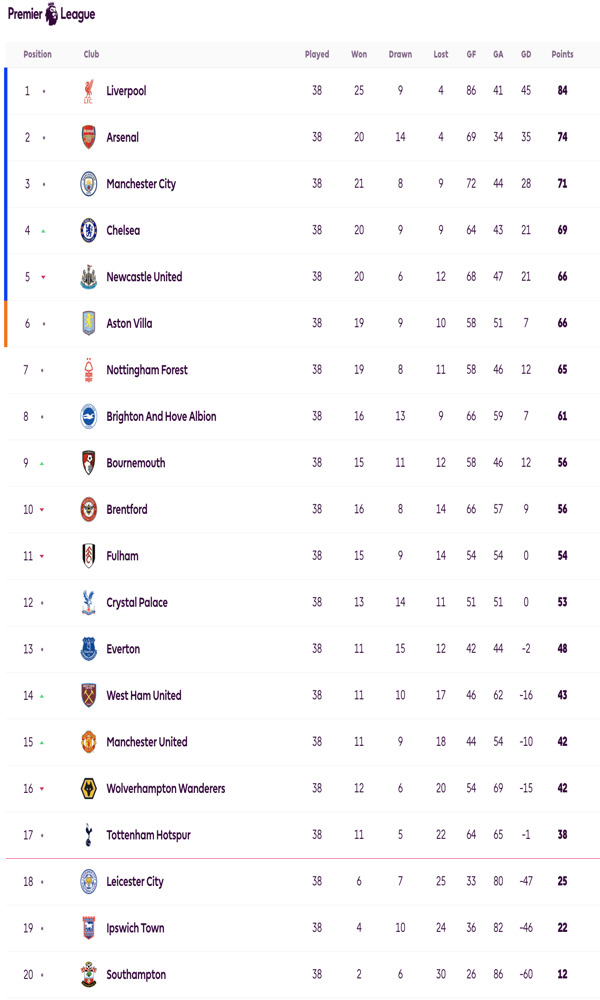

In [3]:
from PIL import Image

Image.open("example_images/24-25-pl.png").resize((600, 1000)) # for checking the image

In [4]:
pl_messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": "example_images/24-25-pl.png",
            },
            {"type": "text", "text": "OCR and return markdown"},
        ],
    }
]

pl_rl_output = inference(rl_model, pl_messages, temperature=0.2)#, do_sample=False)

In [5]:
print(pl_rl_output[0])

<think>
</think>

```markdown
| Position | Club | Played | Won | Drawn | Lost | GF | GA | GD | Points |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | Liverpool | 38 | 25 | 9 | 4 | 86 | 41 | 45 | 84 |
| 2 | Arsenal | 38 | 20 | 14 | 4 | 69 | 34 | 35 | 74 |
| 3 | Manchester City | 38 | 21 | 8 | 9 | 72 | 44 | 28 | 71 |
| 4 | Chelsea | 38 | 20 | 9 | 9 | 64 | 43 | 21 | 69 |
| 5 | Newcastle United | 38 | 20 | 6 | 12 | 68 | 47 | 21 | 66 |
| 6 | Aston Villa | 38 | 19 | 9 | 10 | 58 | 51 | 7 | 66 |
| 7 | Nottingham Forest | 38 | 19 | 8 | 11 | 58 | 46 | 12 | 65 |
| 8 | Brighton And Hove Albion | 38 | 16 | 13 | 9 | 66 | 59 | 7 | 61 |
| 9 | Bournemouth | 38 | 15 | 11 | 12 | 58 | 46 | 12 | 56 |
| 10 | Brentford | 38 | 16 | 8 | 14 | 66 | 57 | 9 | 56 |
| 11 | Fulham | 38 | 15 | 9 | 14 | 54 | 54 | 0 | 54 |
| 12 | Crystal Palace | 38 | 13 | 14 | 11 | 51 | 51 | 0 | 53 |
| 13 | Everton | 38 | 11 | 15 | 12 | 42 | 44 | -2 | 48 |
| 14 | West Ham United | 38 | 11 | 10 | 17 | 46 | 62 | -16

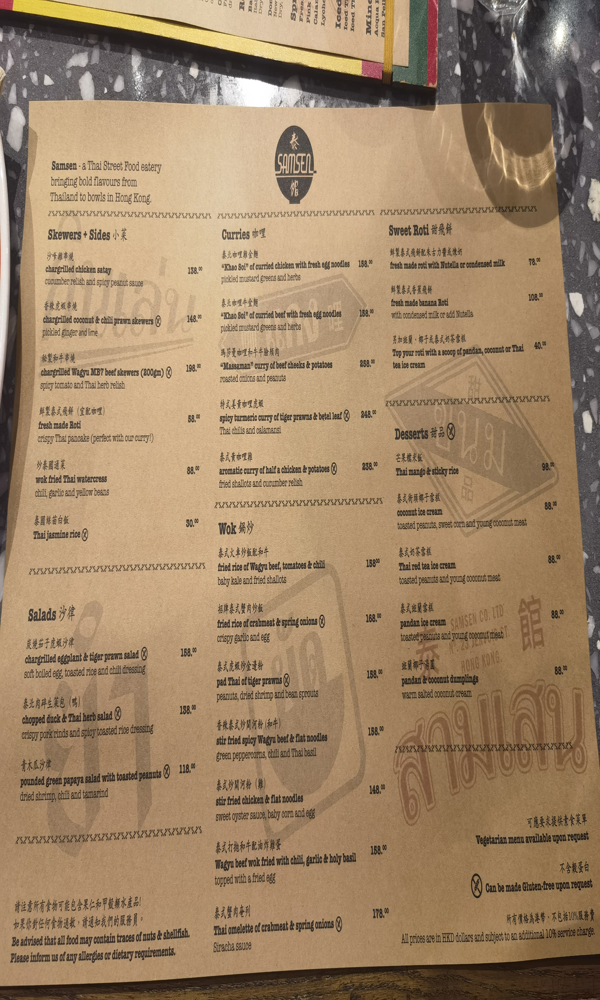

In [6]:
Image.open("example_images/menu.jpeg").resize((600, 1000))

In [7]:
# handwritten 
menu_messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": "example_images/menu.jpeg",
            },
            {"type": "text", "text": "OCR 图中文字"},
        ],
    }
]
print(menu_messages)
sft_output = inference(sft_model, menu_messages, temperature=0.2)#, do_sample=False)

[{'role': 'user', 'content': [{'type': 'image', 'image': 'example_images/menu.jpeg'}, {'type': 'text', 'text': 'OCR 图中文字'}]}]


In [8]:
print(sft_output[0])

<think>
用户现在需要把菜单上的文字OCR出来，要仔细看每个部分。首先看顶部的Samsen - a Thai Street Food eatery bringing bold flavours from Thailand to bowls in Hong Kong. 然后是各个分类：Skewers + Sides 小菜，Curries 咖喱，Sweet Roti 甜飞饼，Salads 沙律，Wok 锅炒，Desserts 甜品，还有底部的注意事项。

先逐行看：

Samsen - a Thai Street Food eatery
bringing bold flavours from
Thailand to bowls in Hong Kong.

Skewers + Sides 小菜
沙爹鸡串烧
char-grilled chicken satay
cucumber relish and spicy peanut sauce 138.00
香辣虎虾串烧
char-grilled coconut & chili prawn skewers 148.00
pickled ginger and lime
秘制和牛串烧
char-grilled Wagyu beef skewers (200gm) 198.00
spicy tomato and Thai herb relish
鲜制泰式飞饼（宜配咖喱）
fresh made Roti
crispy Thai pancake (perfect with our curry!) 58.00
炒泰国通菜
wok fried Thai watercress
chili, garlic and yellow beans 88.00
泰国丝苗白饭
Thai jasmine rice 30.00

Curries 咖喱
泰北咖喱鸡金面
“Khao Soi” of curried chicken with fresh egg noodles
pickled mustard greens and herbs 158.00
泰北咖喱牛金面
“Khao Soi” of curried beef with fresh egg noodles
pickled mustard greens and herbs 158.00
玛莎曼咖喱和牛